# Imports

In [1]:
#Data
import pandas as pd
import numpy as np

#Viz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#Other
from itertools import product
from sklearn.metrics import confusion_matrix
from scipy import stats

# Load in data

In [6]:
#load in data from the experiment
data = pd.read_json('data/data.json')

In [14]:
#Sort dataframe by party voted
order = {'A: Socialdemokratiet': 'A',
         'B: Radikale': 'B',
         'C: Konservative': 'C',
         'D: Nye Borgerlige': 'D',
         'F: SF': 'E',
         'I: Liberal Alliance': 'F',
         'K: Kristendemokraterne': 'G',
         'M: Moderaterne': 'H',
         'O: Dansk Folkeparti': 'I',
         'Q: Frie Grønne': 'J',
         'V: Venstre': 'K',
         'Æ: Danmarksdemokraterne': 'L',
         'Ø: Enhedslisten': 'M',
         'Å: Alternativet': 'N',
         'Jeg stemte ikke': 'O'}
 
data = data.sort_values(by='Voted', key=lambda x: x.map(order))

# Check for wrong ratings

In [15]:
#Make pair of models:
modelsPairs = [('Euclidean', 'QDA'),
                ('Euclidean', 'Manhattan'),
                ('Euclidean', 'Random'),
                ('QDA', 'Manhattan'),
                ('QDA', 'Random'),
                ('Manhattan', 'Random')]

In [16]:
def checkScore(data, modelsPairs):
    """
    Finds the indexes where the parti is the same, 
    but there have been given different scores
    """

    indexs = []
    for i in modelsPairs:
        temp = data[[i[0], i[1], str(i[0])+'Score', str(i[1])+'Score']]
        for index, row in temp.iterrows():
            if row[i[0]] == row[i[1]] and row[str(i[0])+'Score'] != row[str(i[1])+'Score']:
                indexs.append(index)

    return set(indexs)


In [17]:
def solveProblemWithScores(index, listOfScores, data):
    dataNew = data.copy()
    score = 0
    for i in listOfScores:
        score += int(dataNew.loc[index, i+'Score'])
    avgScore = score/len(listOfScores)

    for i in listOfScores:
        dataNew.loc[index, i+'Score'] = avgScore
    return dataNew 

In [18]:
indexs = checkScore(data, modelsPairs)
indexs

{6, 13, 22, 68, 88}

In [19]:
data = solveProblemWithScores(4, ['Euclidean', 'Manhattan', 'QDA'], data)
data = solveProblemWithScores(9, ['Euclidean', 'Manhattan', 'Random'], data)
data = solveProblemWithScores(16, ['Manhattan', 'QDA'], data)
data = solveProblemWithScores(54, ['Euclidean', 'Manhattan', 'QDA'], data)
data = solveProblemWithScores(68, ['Manhattan', 'QDA'], data)

# About the users

In [20]:
print('Gender of the users: ', data['Gender'].value_counts())

Gender of the users:  female        70
male          48
non-binary     1
Name: Gender, dtype: int64


In [21]:
print('Minimum age: ', data['Age'].min())
print('Maximum age: ', data['Age'].max())

Minimum age:  19
Maximum age:  79


In [22]:
#Make the right and left wing
red = "#d8031c"
blue = "#01016f"

windDic = {'A: Socialdemokratiet': 'Red',
         'B: Radikale': 'Red',
         'C: Konservative': 'Blue',
         'D: Nye Borgerlige': 'Blue',
         'F: SF': 'Red',
         'I: Liberal Alliance': 'Blue',
         'K: Kristendemokraterne': 'Blue',
         'M: Moderaterne': 'Blue',
         'O: Dansk Folkeparti': 'Blue',
         'Q: Frie Grønne': 'Red',
         'V: Venstre': 'Blue',
         'Æ: Danmarksdemokraterne': 'Blue',
         'Ø: Enhedslisten': 'Red',
         'Å: Alternativet': 'Red',
         'Jeg stemte ikke': '0'}

## Age distribution

In [23]:
#Make data with wing column, that represents the wing of which the user voted for
leftRightWing = data.copy()
leftRightWing['Wing'] = data['Voted']
leftRightWing['Wing'].replace(windDic, inplace= True)

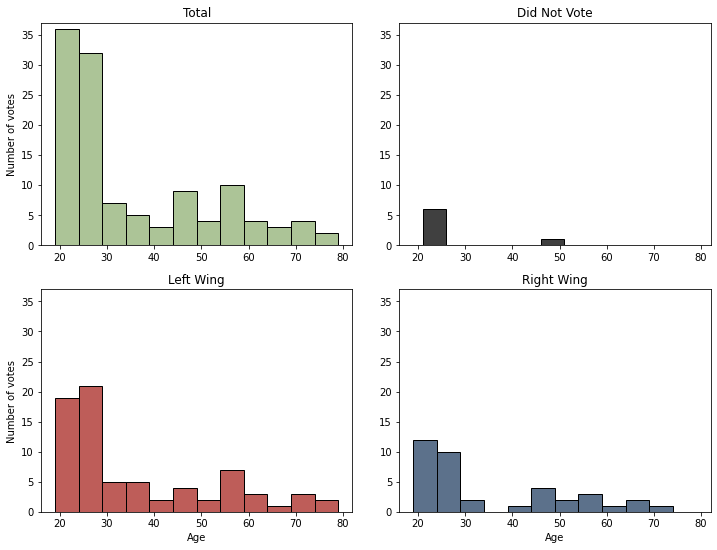

In [24]:
cross_tab = pd.crosstab(index=leftRightWing['Age'], columns=leftRightWing['Wing'])

x = cross_tab.index
y1 = cross_tab['Red']
y2 = cross_tab['Blue']
y3 = cross_tab['0']

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.subplots_adjust(hspace=0.2, wspace=0.15)

#Add plots
sns.histplot(ax=axes[0, 0], data=leftRightWing, x='Age', binwidth=5, color = '#90B075')
sns.histplot(ax=axes[1, 0], data=leftRightWing[leftRightWing['Wing'] == 'Red'], x='Age', color = '#A82721', binwidth=5)
sns.histplot(ax=axes[0, 1], data=leftRightWing[leftRightWing['Wing'] == '0'], x='Age', color = '#000000', binwidth=5)
sns.histplot(ax=axes[1, 1], data=leftRightWing[leftRightWing['Wing'] == 'Blue'], x='Age', color = '#254264', binwidth=5)

#Uniform x-axis
axes[0, 0].set_xlim(16,82)
axes[0, 1].set_xlim(16,82)
axes[1, 0].set_xlim(16,82)
axes[1, 1].set_xlim(16,82)

#Uniform x-axis
axes[0,0].set_ylim(0,37)
axes[0,1].set_ylim(0,37)
axes[1,0].set_ylim(0,37)
axes[1,1].set_ylim(0,37)

#Add Title
axes[0,0].set_title('Total')
axes[1,0].set_title('Left Wing')
axes[0,1].set_title('Did Not Vote')
axes[1,1].set_title('Right Wing')


#Add y-label
axes[0,0].set_ylabel('Number of votes')
axes[1,0].set_ylabel('Number of votes')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')

#Remove x-lable
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')

plt.savefig("results pics/age distribution.png", dpi=300, bbox_inches='tight')

In [25]:
cross_tab.sum()

Wing
0        7
Blue    38
Red     74
dtype: int64

In [26]:
print('Mean of the ages: ', int(data['Age'].mean()))
print('STD of the ages: ', int(data['Age'].std()))

Mean of the ages:  35
STD of the ages:  16


In [27]:
colors = {'Jeg stemte ikke':"#000000",
 'A: Socialdemokratiet':"#A82721",
 'B: Radikale':"#733280",
 'C: Konservative':"#96B226",
 'D: Nye Borgerlige':"#127B7F",
 'F: SF':"#E07EA8",
 'I: Liberal Alliance':"#3FB2BE",
 'K: Kristendemokraterne':"#8B8474",
 'M: Moderaterne':"#B48CD2",
 'O: Dansk Folkeparti':"#EAC73E",
 'Q: Frie Grønne':"#5ABE82",
 'V: Venstre':"#254264",
 'Æ: Danmarksdemokraterne':"#7896D2",
 'Ø: Enhedslisten':"#E6801A",
 'Å: Alternativet':"#2B8738"}

## What the users voted

In [28]:
def getMacthPlot(data, model, order):
    plt.figure(figsize=(10,8))
    ax = sns.countplot(data=data.sort_values(by=model, key=lambda x: x.map(order)), x=model, palette= colors)
    ax.set(ylabel='Number of matches')
    plt.xticks(rotation=45, horizontalalignment = "right")
    plt.savefig("results pics/matches " + model +  ".png", dpi=300, bbox_inches='tight')

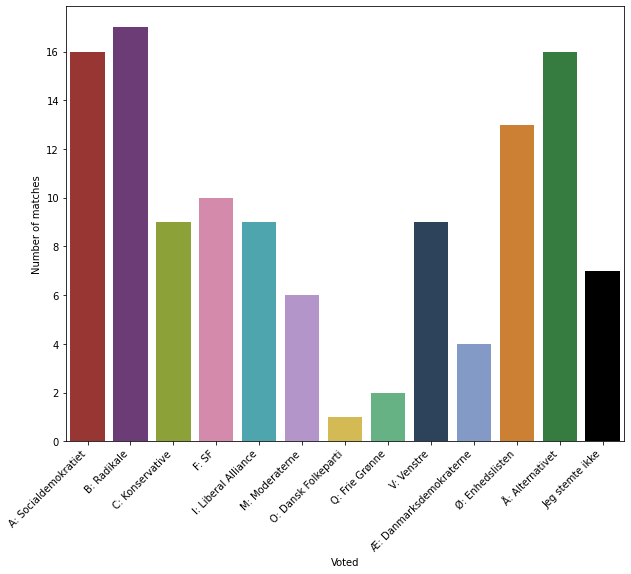

In [29]:
getMacthPlot(data, 'Voted', order)

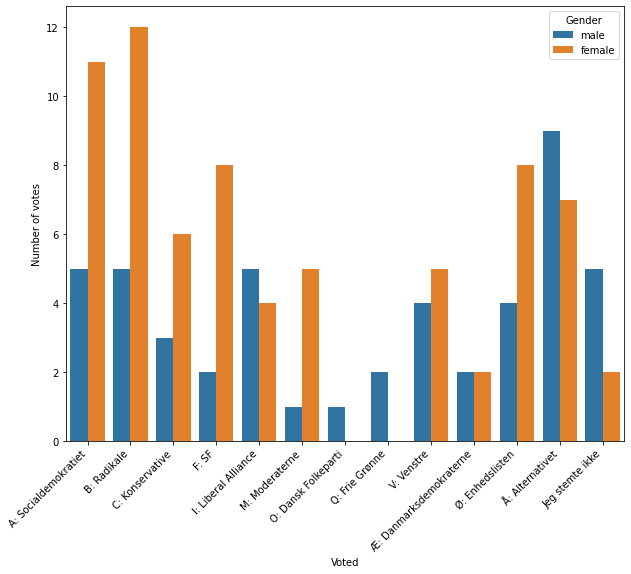

In [30]:
#Voted by gender
plt.figure(figsize=(10,8))
ax = sns.countplot(data = data[data['Gender'] != 'non-binary'].sort_values(by='Voted', key=lambda x: x.map(order)), x='Voted', hue="Gender", hue_order=['male', 'female'])
ax.set(ylabel='Number of votes')
plt.xticks(rotation=45, horizontalalignment = "right")
plt.savefig("results pics/gender votes.png", dpi=300, bbox_inches='tight')

## Percentages of men and female votes

In [31]:
genderPercent = data.groupby(['Gender', 'Voted'])['Voted'].count().reset_index(name = 'Count')
genderCount = [70 for i in range(11)] + [45 for i in range(13)] + [1]
genderPercent['Total'] = genderCount
genderPercent['Percentage'] = (genderPercent['Count']/genderPercent['Total'])*100
genderPercent['Wing'] = genderPercent['Voted']
genderPercent['Wing'].replace(windDic, inplace= True)
genderPercent

,Gender,Voted,Count,Total,Percentage,Wing
0,female,A: Socialdemokratiet,11,70,15.714286,Red
1,female,B: Radikale,12,70,17.142857,Red
2,female,C: Konservative,6,70,8.571429,Blue
3,female,F: SF,8,70,11.428571,Red
4,female,I: Liberal Alliance,4,70,5.714286,Blue
5,female,Jeg stemte ikke,2,70,2.857143,0
6,female,M: Moderaterne,5,70,7.142857,Blue
7,female,V: Venstre,5,70,7.142857,Blue
8,female,Å: Alternativet,7,70,10.000000,Red
9,female,Æ: Danmarksdemokraterne,2,70,2.857143,Blue


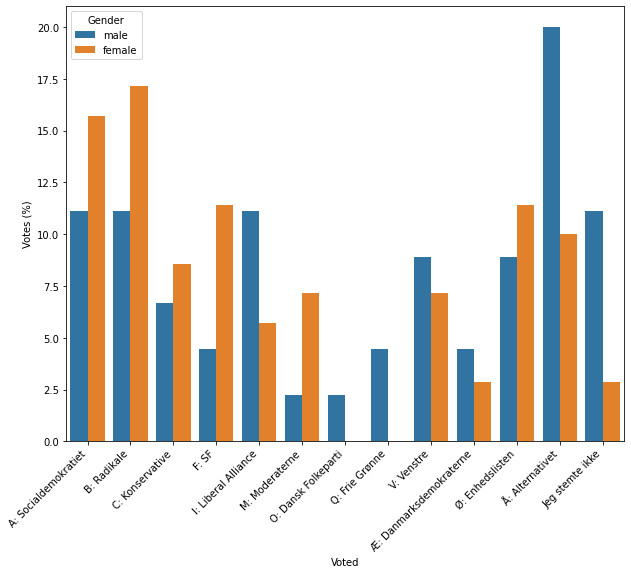

In [32]:
#Voted by gender
plt.figure(figsize=(10, 8))
ax = sns.barplot(data = genderPercent[genderPercent['Gender'] != 'non-binary'].sort_values(by='Voted', key=lambda x: x.map(order)), x = 'Voted', y='Percentage', hue="Gender",hue_order=['male', 'female'])
ax.set(ylabel='Votes (%)')
plt.xticks(rotation=45, horizontalalignment = "right")
plt.savefig("results pics/gender votes percentage.png", dpi=300, bbox_inches='tight')

# What did the models say?

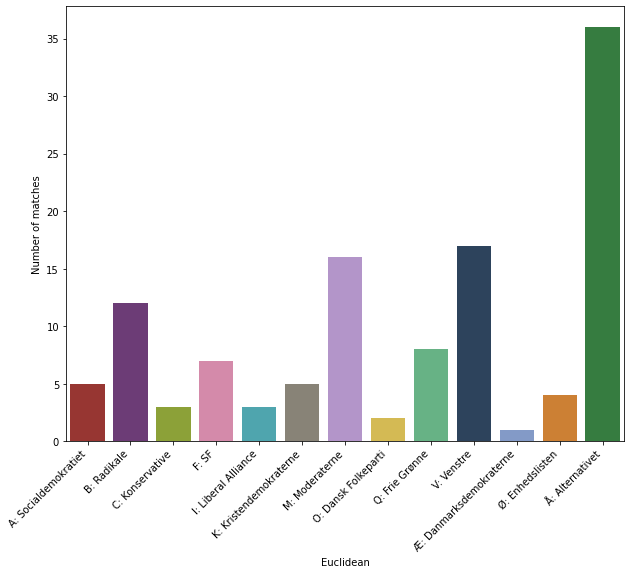

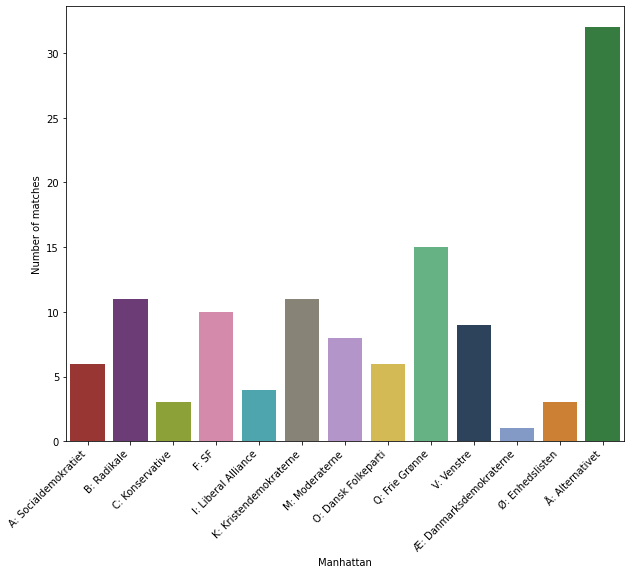

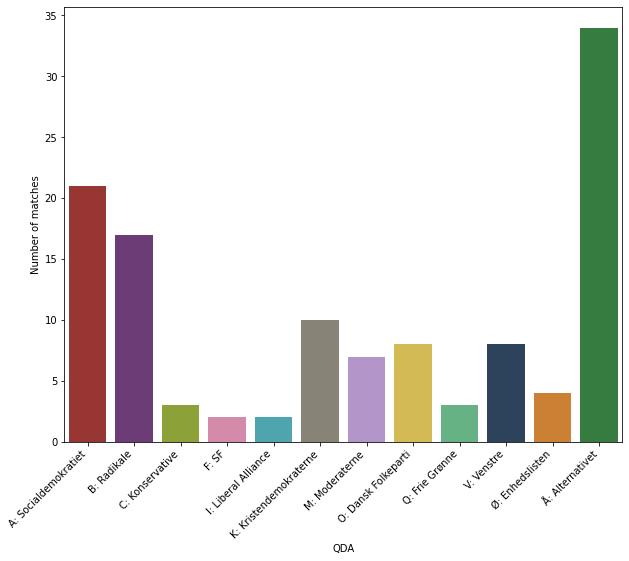

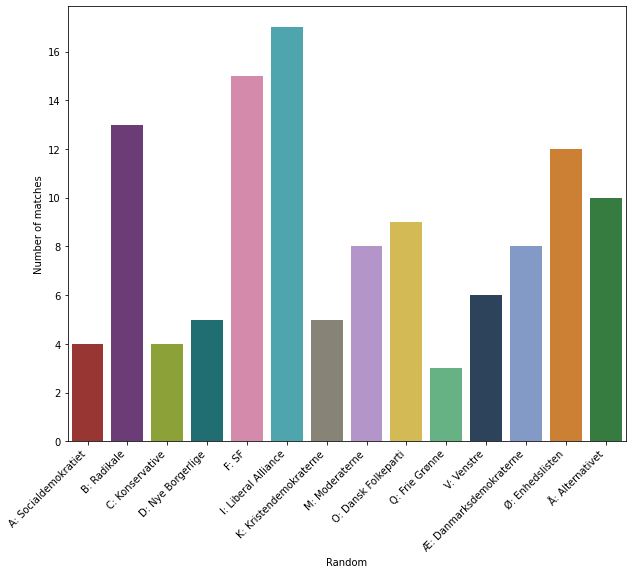

In [33]:
models = ['Euclidean', 'Manhattan', 'QDA', 'Random']
for i in models:
    getMacthPlot(data, i, order)

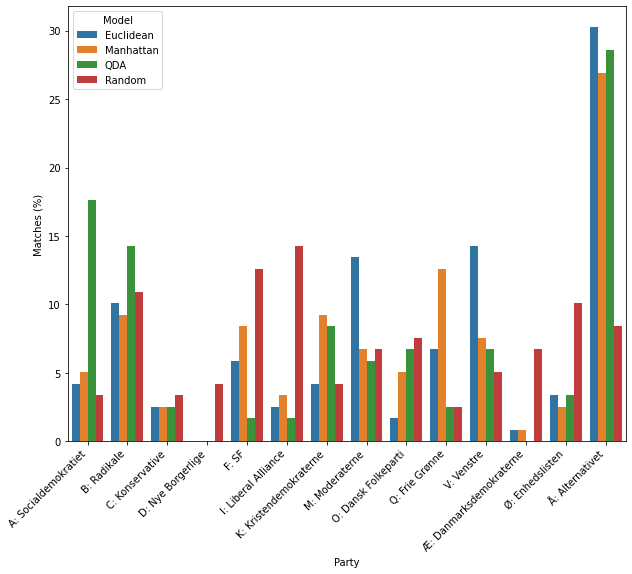

In [58]:
matchData = data[['Euclidean', 'Manhattan', 'QDA', 'Random']]
matchData = pd.melt(matchData)
matchData.rename(columns = {'value': 'Party', 'variable': 'Model'}, inplace = True)
matchData = matchData.groupby(['Model', 'Party'])['Party'].count().reset_index(name = 'Count')
matchData['Total'] = 119
matchData['Percent'] = (matchData['Count']/matchData['Total'])*100
matchData.sort_values(by='Party', key=lambda x: x.map(order), inplace= True)

plt.figure(figsize=(10,8))
ax = sns.barplot(data = matchData, x='Party', y = 'Percent', hue = 'Model', hue_order=['Euclidean', 'Manhattan', 'QDA', 'Random'])
ax.set(ylabel='Matches (%)')
plt.xticks(rotation=45, horizontalalignment = "right")

plt.savefig("results pics/matches for all models.png", dpi=300, bbox_inches='tight')

# Agreement between user and the models

In [ ]:
euclideanPoint = 0
mahattanPoint = 0
qdaPoint = 0
randomPoint = 0

for index, row in data.iterrows():
    if row['Euclidean'] == row['Voted']:
        euclideanPoint += 1
    if row['Manhattan'] == row['Voted']:
        mahattanPoint += 1
    if row['QDA'] == row['Voted']:
        qdaPoint += 1
    if row['Random'] == row['Voted']:
        randomPoint += 1    

In [ ]:
print('Times the euclidean, found what the user voted for: ', euclideanPoint/112)
print('Times the manhattan, found what the user voted for: ', mahattanPoint/112)
print('Times the QDA, found what the user voted for: ', qdaPoint/112)
print('Times the random, found what the user voted for: ', randomPoint/112)

Times the euclidean, found what the user voted for:  0.17857142857142858
Times the manhattan, found what the user voted for:  0.16964285714285715
Times the QDA, found what the user voted for:  0.29464285714285715
Times the random, found what the user voted for:  0.10714285714285714


# Party miss match

In [ ]:
def getConfusionMatrixPlot(data, model):
    partyLabels =  ['A: Socialdemokratiet',
                        'B: Radikale',
                        'C: Konservative',
                        'D: Nye Borgerlige',
                        'F: SF',
                        'I: Liberal Alliance',
                        'K: Kristendemokraterne',
                        'M: Moderaterne',
                        'O: Dansk Folkeparti',
                        'Q: Frie Grønne',
                        'V: Venstre',
                        'Æ: Danmarksdemokraterne',
                        'Ø: Enhedslisten',
                        'Å: Alternativet',
                        'Jeg stemte ikke']
    parties = set(data['Voted'].unique().tolist() + data[model].unique().tolist())
    for i in partyLabels:
        if i not in parties:
            partyLabels.remove(i)

    x = confusion_matrix(data['Voted'], data[model], labels = partyLabels)
    print(x.sum())
    plt.figure(figsize=(5,5))
    cmap = sns.color_palette("Blues", as_cmap=True)
    ax = sns.heatmap(x, 
                    annot = True, 
                    square = True, 
                    linecolor ='black', 
                    linewidths = 1, 
                    cbar=False,
                    cmap = cmap)
    ax.xaxis.set_ticklabels(partyLabels) 
    ax.yaxis.set_ticklabels(partyLabels)
    #ax.set(title= 'What the user voted and what the ' + model + ' predicted')
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    plt.xlabel('Matched by ' + model)
    plt.ylabel('Voted in 2022')
    plt.yticks(rotation= 0, horizontalalignment = "right")
    plt.xticks(rotation= 45, horizontalalignment = "right")
    plt.savefig("results pics/confusion matrix " + model + ".png", dpi=300, bbox_inches='tight')
    

119
119
119
119


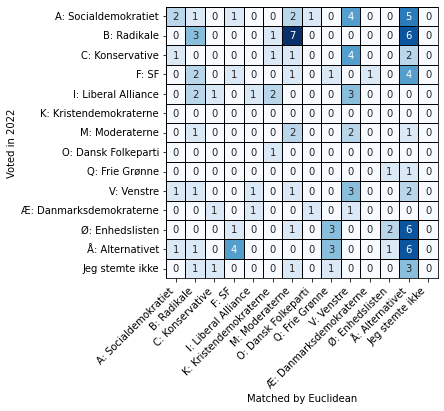

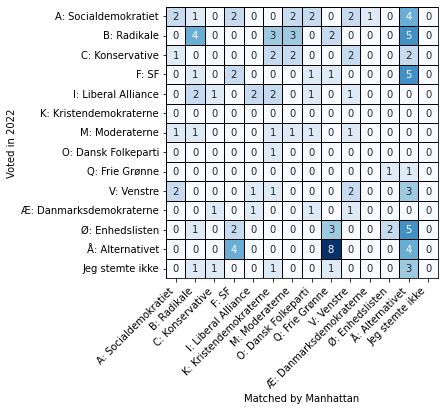

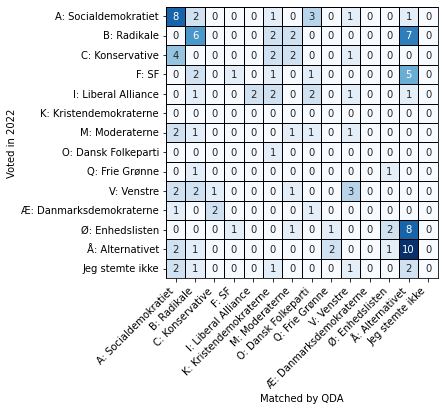

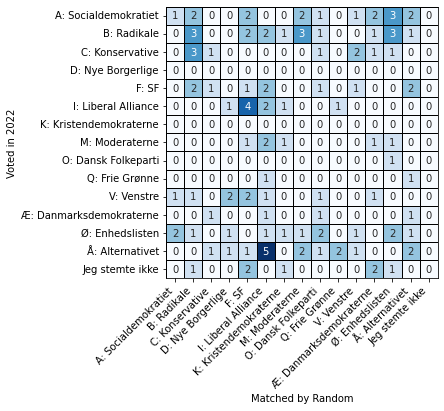

In [ ]:
for i in models:
    getConfusionMatrixPlot(data, i)

# Scores of the models

In [ ]:
print("The QDA score is: ", data['QDAScore'].mean(), ' with a STDV of ', data['QDAScore'].std())
print("The Euclidean score is: ", data['EuclideanScore'].mean(), ' with a STDV of ', data['EuclideanScore'].std())
print("The Manhattan score is: ", data['ManhattanScore'].mean(), ' with a STDV of ', data['ManhattanScore'].std())
print("The Random score is: ", data['RandomScore'].mean(), ' with a STDV of ', data['RandomScore'].std())

The QDA score is:  4.571428571428571  with a STDV of  2.064926758546125
The Euclidean score is:  4.397759103641456  with a STDV of  2.0576792510121433
The Manhattan score is:  4.162464985994397  with a STDV of  2.077530017150867
The Random score is:  3.0028011204481793  with a STDV of  2.107513148931166


In [ ]:
scoreData = data[['EuclideanScore', 'ManhattanScore', 'QDAScore', 'RandomScore']]
scoreData = pd.melt(scoreData)
scoreData.rename(columns = {'value': 'Score', 'variable': 'Model'}, inplace = True)
scoreData.replace({'ManhattanScore': 'Manhattan', 'EuclideanScore': 'Euclidean', 'QDAScore': 'QDA', 'RandomScore': 'Random'}, inplace = True)

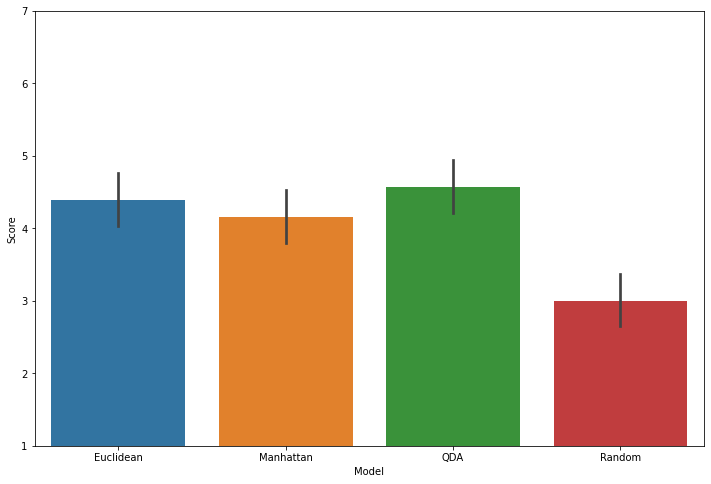

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=scoreData, x="Model", y="Score", hue_order= models)
plt.ylim(1, 7)
plt.savefig('results pics/scores of the models.png', dpi=300, bbox_inches='tight')

In [ ]:
scoreData.groupby(by = 'Model').median()

,Score
Model,
Euclidean,5.0
Manhattan,4.0
QDA,5.0
Random,2.0


In [ ]:
t = scoreData.groupby(by = 'Model')['Score'].value_counts().reset_index(name = 'Count')
t.sort_values('Score')

,Model,Score,Count
2,Euclidean,1.000000,20
23,Random,1.000000,47
9,Manhattan,1.000000,26
19,QDA,1.000000,19
25,Random,2.000000,14
6,Euclidean,2.000000,5
22,QDA,2.000000,5
14,Manhattan,2.000000,1
27,Random,3.000000,10
5,Euclidean,3.000000,10


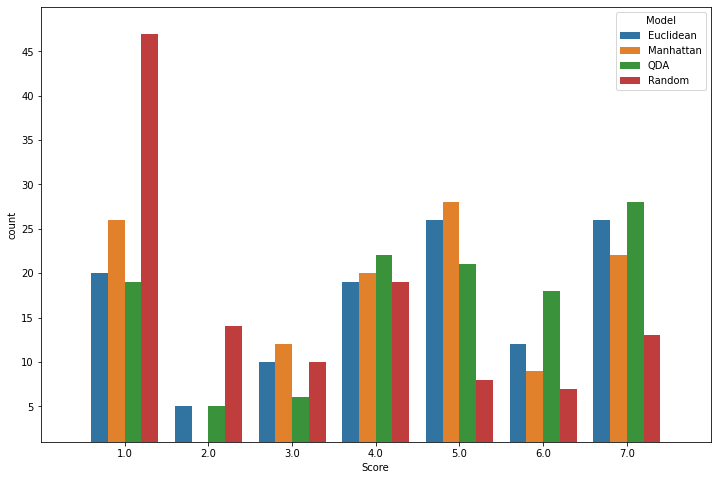

In [ ]:
plt.figure(figsize=(12,8))
p = sns.countplot(scoreData[scoreData['Score'] != 3.3333333333333335], x="Score", hue="Model", hue_order= models)
plt.yticks([i for i in range(0,50,5)])
plt.ylim(1, 50)
plt.xlim(-1, 7)
plt.savefig('results pics/score distribution.png', dpi=300, bbox_inches='tight')

In [ ]:
print('All models: ', stats.kruskal(data['EuclideanScore'], data['ManhattanScore'], data['QDAScore'], data['RandomScore'])[1])

All models:  4.872802478883577e-08


In [ ]:
pValues = {}

for i in models:
    temp = []
    for j in models:
        temp.append(stats.kruskal(data[i+'Score'], data[j+'Score'])[1])
    pValues[i] = temp

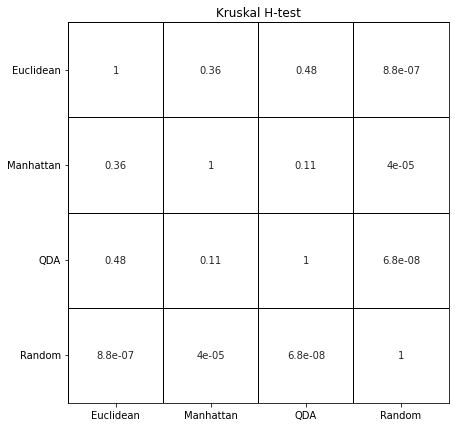

In [ ]:
df = pd.DataFrame.from_dict(pValues, orient= 'index', columns =['Euclidean', 'Manhattan', 'QDA', 'Random'])
plt.figure(figsize=(7,7))
ax = sns.heatmap(df, annot = True, square = True, cmap = ListedColormap(['white']), linecolor ='black', linewidths = 1, cbar=False)
plt.yticks(rotation= 0, horizontalalignment = "right")
ax.set(title= 'Kruskal H-test')
for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.savefig('results pics/Kruskal H-test.png', dpi=300, bbox_inches='tight')

# Agreement between the models

In [ ]:
scoreDict = {'Euclidean': [],
            'Manhattan': [],
            'QDA': [],
            'Random': []}

for modelOne in models:
    for modelTwo in models:
        count = 0
        for index, row in data.iterrows():
            if row[modelOne] == row[modelTwo]:
                count += 1
        l = scoreDict[modelOne]
        l.append((count/len(data)))
        scoreDict[modelOne] = l

In [ ]:
scoreData = pd.DataFrame.from_dict(scoreDict, orient= "index", columns= models)

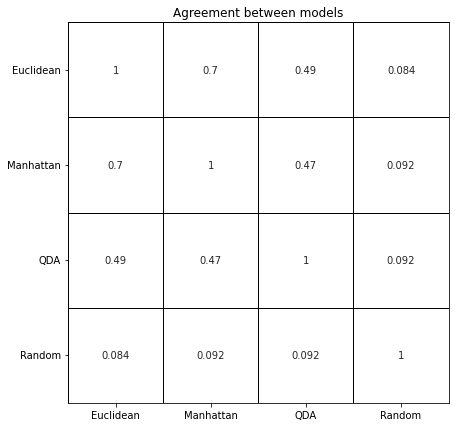

In [ ]:
plt.figure(figsize=(7,7))
ax = sns.heatmap(scoreData, annot = True, square = True, cmap = ListedColormap(['white']), linecolor ='black', linewidths = 1, cbar=False)
plt.yticks(rotation= 0, horizontalalignment = "right")
ax.set(title= 'Agreement between models')
for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.savefig('results pics/agreement between models.png', dpi=300, bbox_inches='tight')